# Google Stock Price Prediction
![](https://moneyexcel.com/wp-content/uploads/2018/06/stock-price.png)

**Description:**
This notebook demonstrates real time stock prediction using the trends of past 60 days as input built using a recurrent neural network. Recurrent neural networks with basic, LSTM cells are implemented.

**Dataset:**
The training set contains Google stock price values from January, 2012 to December, 2020. The test set contains the Google stock price values from January, 2021 to September, 2021. 
Dataset has been extracted from the site https://finance.yahoo.com/quote/GOOG/history/

**Content:**

1. Importing Libraries and Dataset
2. Exploratory Data Analysis
3. Data Preprocessing
4. Model Building and Training
5. Model Predictions


# Importing the Libraries and dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2021-09-14 12:10:51.901928: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-14 12:10:51.902043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_train = pd.read_csv('../input/google-stock-price-201221/train.csv')
df_test = pd.read_csv('../input/google-stock-price-201221/test.csv')

# Exploratory Data Analysis

In [3]:
print(df_train.shape, df_test.shape)

(2264, 7) (175, 7)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2264 non-null   object 
 1   Open       2264 non-null   float64
 2   High       2264 non-null   float64
 3   Low        2264 non-null   float64
 4   Close      2264 non-null   float64
 5   Adj Close  2264 non-null   float64
 6   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 123.9+ KB


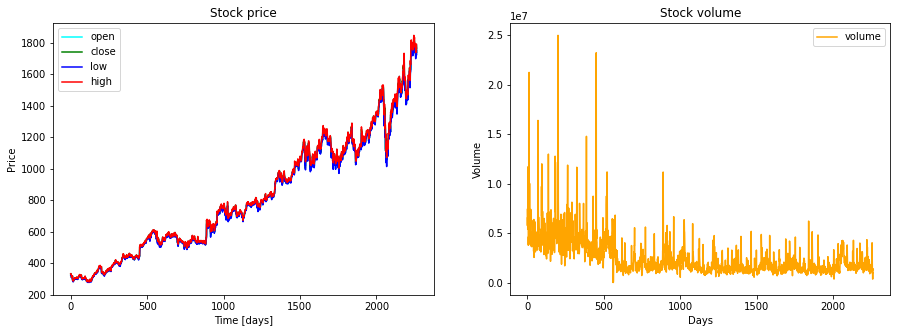

In [13]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(df_train.Open, color='cyan', label='open')
plt.plot(df_train.Close, color='green', label='close')
plt.plot(df_train.Low, color='blue', label='low')
plt.plot(df_train.High, color='red', label='high')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df_train.Volume, color='orange', label='volume')
plt.title('Stock volume')
plt.xlabel('Days')
plt.ylabel('Volume')
plt.legend(loc='best')

plt.show()

# Data Preprocessing

I am building the model around the column Open so generating a training set seperately using that. 

In [15]:
train_set = df_train.iloc[:,1:2].values

## Feature Scaling: Why Normalization?
Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/Norm_eq.gif)

It will be beneficial to normalize your training data. Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation. Despite that the whole discussion on data preprocessing is controversial either on when exactly it is necessary and how to correctly normalize the data for each given model and application domain there is a general consensus in Machine Learning that running a general Normalization preprocessing step is helpful.

In [16]:
sc = MinMaxScaler(feature_range = (0,1))
train_set_scaled = sc.fit_transform(train_set)

In [17]:
print(train_set_scaled)

[[0.02984808]
 [0.03374509]
 [0.03281033]
 ...
 [0.95283733]
 [0.97623265]
 [0.95955082]]


All the values have been pushed between 0 and 1.

Next, I will generate a data structure that could hold 1 output for each set of 60 timesteps. I will develop a network that will be able to predict the current trend for the Stock price based on 60 timesteps.

In [19]:
x_train = []
y_train = []
 
for i in range(60,2264):
    x_train.append(train_set_scaled[i-60:i,0])
    y_train.append(train_set_scaled[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train

array([[0.02984808, 0.03374509, 0.03281033, ..., 0.02728875, 0.02794308,
        0.02955475],
       [0.03374509, 0.03281033, 0.03184977, ..., 0.02794308, 0.02955475,
        0.03000924],
       [0.03281033, 0.03184977, 0.02777225, ..., 0.02955475, 0.03000924,
        0.0294645 ],
       ...,
       [0.77982993, 0.7654388 , 0.76814357, ..., 0.94170429, 0.93761468,
        0.9420731 ],
       [0.7654388 , 0.76814357, 0.77420673, ..., 0.93761468, 0.9420731 ,
        0.95283733],
       [0.76814357, 0.77420673, 0.76690122, ..., 0.9420731 , 0.95283733,
        0.97623265]])

In [21]:
y_train

array([0.03000924, 0.0294645 , 0.02592527, ..., 0.95283733, 0.97623265,
       0.95955082])

In [23]:
print(x_train.shape , y_train.shape)

(2204, 60) (2204,)


As we can see, we need to make variable x_train 3 dimensional so that it can be given as the input to our Recurrent Neural Network. A single training example for LSTM network consists of a sequence and a label and hence, it needs to be converted to 3 dimensional structure.

In [25]:
x_train = x_train.reshape(2204, 60, 1)
x_train.shape

(2204, 60, 1)

# Model Building and Training

Here, the first task for us is to initialize our RNN model. The key is to develop a basic model at first and then keep on tuning the Hyper parameters for a better fit and balancing the Bias-Variance Trade off. 

In this model, I have used 4 LSTM layers followed by Dropout. Adding a Dropout layer helps our model with regularization and prevents overfitting.

## LSTM: 
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video).

![](https://static.javatpoint.com/tutorial/tensorflow/images/long-short-term-memory-rnn-in-tensorflow.jpg)

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, activation = 'relu', return_sequences = True, input_shape = (249, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(60, activation = 'relu', return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(80, activation = 'relu', return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(120, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

2021-09-14 12:52:34.789116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 12:52:34.795594: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-14 12:52:34.795647: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-14 12:52:34.795714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5cb565e6caa7): /proc/driver/nvidia/version does not exist
2021-09-14 12:52:34.798928: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 249, 60)           14880     
_________________________________________________________________
dropout (Dropout)            (None, 249, 60)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 249, 60)           29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 249, 80)           45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 249, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

Now, to compile our model I choose the Adam Optimizer and for loss function I use the infamous Mean Squared Error as our problem deals with continuous Numerical data. 

**Adam:** Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

**Mean Squared error:** In statistics, the mean squared error (MSE) or mean squared deviation (MSD) of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.

In [29]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [30]:
model.fit(x_train, y_train, 32, 100)

2021-09-14 12:58:08.796229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-14 12:58:08.810232: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/100
69/69 [==============================] - 14s 135ms/step - loss: 0.0624
Epoch 2/100
69/69 [==============================] - 9s 130ms/step - loss: 0.0032
Epoch 3/100
69/69 [==============================] - 9s 133ms/step - loss: 0.0026
Epoch 4/100
69/69 [==============================] - 9s 132ms/step - loss: 0.0027
Epoch 5/100
69/69 [==============================] - 9s 136ms/step - loss: 0.0027
Epoch 6/100
69/69 [==============================] - 9s 135ms/step - loss: 0.0025
Epoch 7/100
69/69 [==============================] - 9s 135ms/step - loss: 0.0031
Epoch 8/100
69/69 [==============================] - 9s 136ms/step - loss: 0.0021
Epoch 9/100
69/69 [==============================] - 9s 135ms/step - loss: 0.0021
Epoch 10/100
69/69 [==============================] - 9s 134ms/step - loss: 0.0021
Epoch 11/100
69/69 [==============================] - 9s 130ms/step - loss: 0.0021
Epoch 12/100
69/69 [==============================] - 9s 132ms/step - loss: 0.0016
Epoch 13/100

# Model Predictions!!

Making a data structure such that it holds the Stock market trends for Two months of 2021 i.e. January and Februrary.

In [38]:
curr_stock_price = df_test.iloc[0:45,1:2].values
curr_stock_price.shape

(45, 1)

In [32]:
#Concatenating the training and test set
df_total = pd.concat((df_train['Open'], df_test['Open']), axis=0)

#Getting the stock prices of previous 60 days for each day of months Jan,2021 and Feb,2021
inputs = df_total[len(df_total)-len(df_test)-60:].values
inputs = inputs.reshape(-1,1)

#Normalization (as discussed earlier)
inputs = sc.transform(inputs)

#Making a Test Set
x_test = []
for i in range(60, 100):
    x_test.append(inputs[i-60:i,0])

#Converting the test set into a Numpy array
x_test = np.array(x_test)

#Since RNN, accepts 3D input we need to reshape the test set again
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

#Here, we predict the stock prices and Denormalize our predicted values for plotting
pred_stock_price = model.predict(x_test)
pred_stock_price = sc.inverse_transform(pred_stock_price)

In [34]:
for i in range(0,10):
    print(pred_stock_price[i], curr_stock_price[i])

[1683.6448] [1757.540039]
[1685.8032] [1725.]
[1679.268] [1702.630005]
[1666.5896] [1740.060059]
[1657.7784] [1787.97998]
[1663.7755] [1786.069946]
[1674.607] [1753.920044]
[1679.0691] [1738.579956]
[1676.7732] [1753.619995]
[1674.4696] [1738.189941]


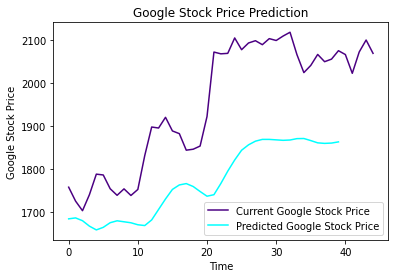

In [41]:
plt.plot(curr_stock_price, color='indigo', label='Current Google Stock Price') 
plt.plot(pred_stock_price, color='cyan', label='Predicted Google Stock Price') 
plt.title('Google Stock Price Prediction') 
plt.ylabel('Google Stock Price')
plt.xlabel('Time')
plt.legend()
plt.show()

We can see that our model is able to predict the trends of the market. 
### If you like this notebook, please give an Upvote! Don't forget to check out my other notebooks too! ###
1. https://www.kaggle.com/anshankul/ann-for-image-classification-fashion-mnist
2. https://www.kaggle.com/anshankul/feature-selection-feature-engineering-techniques
3. https://www.kaggle.com/anshankul/insurance-charges-prediction

**For Further Reference:**
1. https://stackoverflow.com/questions/43467597/should-i-normalize-my-features-before-throwing-them-into-rnn
2. https://stackoverflow.com/questions/48475255/python-lstm-based-rnn-required-3d-input
3. https://www.geeksforgeeks.org/intuition-of-adam-optimizer/
4. https://en.wikipedia.org/wiki/Mean_squared_error
5. https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru